In [1]:
from music21 import *
import music21
import os
import glob
import re
import numpy as np

In [5]:
for piece in glob.glob("../musicxml(notated)/*.mxl"):
    print(piece)
    c = converter.parse(piece)
    for thisNote in c.recurse().notes:
          print(thisNote,thisNote.lyric)

../musicxml(notated)\Bach_Fugue_in_G_Minor_BWV_578_Piano_solo.mxl
<music21.note.Note G> Gm(I)
<music21.note.Note D> V
<music21.note.Note B-> None
<music21.note.Note A> None
<music21.note.Note G> I
<music21.note.Note B-> None
<music21.note.Note A> None
<music21.note.Note G> None
<music21.note.Note F#> V+
<music21.note.Note A> None
<music21.note.Note D> None
<music21.note.Note G> I
<music21.note.Note D> None
<music21.note.Note A> None
<music21.note.Note D> None
<music21.note.Note B-> None
<music21.note.Note A> None
<music21.note.Note G> None
<music21.note.Note A> None
<music21.note.Note D> None
<music21.note.Note G> None
<music21.note.Note D> None
<music21.note.Note G> None
<music21.note.Note A> None
<music21.note.Note D> None
<music21.note.Note A> None
<music21.note.Note B-> None
<music21.note.Note A> None
<music21.note.Note G> None
<music21.note.Note A> None
<music21.note.Note D> None
<music21.note.Note D> None
<music21.note.Note C> None
<music21.note.Note B-> None
<music21.note.Note A

KeyboardInterrupt: 

In [6]:
for piece in glob.glob("../musicxml(notated)/*.mxl"):
    c = converter.parse(piece)
    partStream = c.parts.stream()
    post = c.flattenParts().flat
    print(piece)
    allText = text.assembleLyrics(post)
    print(allText)
    print("\n")


../musicxml(notated)\Etude_Opus_10_No._11__in_E_Major.mxl



../musicxml(notated)\E╠ütude_in_C_Minor.mxl
Cm(I) II IV I II Dim7 I V+ Fm(Dim7) I+ Cm(II) I II IV I+ ♭II V+ I+ V+ I+ V+ V IV+ IV I+ A♭M(I) V I V IV I GM(V) I Cm(VI) II V+ IV Gm(Dim7) I Cm(Dim7) IV VI II V+7 VI Dm(V+) Dim7 Cm(V+7) I II IV I II I V+ Fm(Dim7) I+ Cm(Dim7) I II I ♭II Fm(Dim7) GermanVI Cm(V+7) II I Fm(V+) I Cm(II) I VI V+7 I+ V+ I V+ IV+ V+ IV+ IV II IV II I+


../musicxml(notated)\E╠ütude_in_F_Major.mxl
FM(I) V I V I V I V I V I V I V I V B♭M(II) V I A♭M(II) V I Cm(VI) V+7 VI V+7 Bm(VI) V+7 VI V+ BM(V) I V I V I V I V I EM(II) V I DM(II) V I F#m(VI) V+7 VI V+7 Fm(VI) V+7 FM(V) I IV V I V I V I I V I V I V I V EM(V) I IV FM(II) V I EM(V) I IV FM(II) V I V I V I V I


../musicxml(notated)\E╠ütude_in_F_Minor.mxl
Fm(I) IV I V+7 I IV I V+ I IV I V+7 Dim7 V+ GermanVI I IV I IV I V+ I IV I I IV I IV I V+ Dim7 V+ I E♭m(V+) I D♭M(V) I V G♭M(IV) V I V D♭m(I) Fm(Dim7) V+7 Dim7 VI V+ I V+ VI V+ VI V+ I V+ I V+ IV V+ I V+7 I V

In [30]:
def demonopolize(notelist):
    if len(notelist) <=2:
        return notelist
    other_values = np.array(list(notelist.values()))
    other_values = other_values[other_values < 0.5]
    maxval = np.max(other_values)
    if len(notelist) <=2:
        return notelist
    hasChanged = True
    dontchange = []
    totalredist = 1
    for note in notelist:
        if notelist[note] >= 0.5:
            notelist[note] = maxval
    return notelist
            

def importance_score(notelist,noteduration,noteoctave):
    allnotes = {}
    for i in range(len(notelist)):
        if not notelist[i] in allnotes:
            allnotes[notelist[i]] = {"occ":1,"durlist":[noteduration[i]],"octavelist":[noteoctave[i]]}
        else:
            allnotes[notelist[i]]['occ'] += 1
            allnotes[notelist[i]]['durlist'].append(noteduration[i])
            allnotes[notelist[i]]['octavelist'].append(noteoctave[i])
    returnnote = {}
    totalscore = 0
    for note in allnotes:
        returnnote[note] = int(allnotes[note]['occ'] * (np.sum(allnotes[note]['durlist'])) * (21-2*np.min(allnotes[note]['octavelist'])))
        if returnnote[note] == 0:
            returnnote[note] = 1
        totalscore += returnnote[note]
    for note in allnotes:
        returnnote[note] = round(returnnote[note]/totalscore,3)
    retunnote = demonopolize(returnnote)
    return returnnote

In [31]:
chord_sequence = {}
i = 0
for piece in glob.glob("../musicxml(notated)/*.mxl"):
#     if i == 0:
#         i += 1
#         continue
    print(piece)
    chords = []
    notes = []
    c = converter.parse(piece)
    partStream = c.parts.stream()
    post = c.flattenParts().flat
    allText = text.assembleLyrics(post)
    print(allText)
    if len(allText) == 0:
        continue
#     firstChord = False
    current_key = ""
    current_chord = ""
    notelist = []
    noteoffset = []
    noteduration = []
    noteoctave = []
    for note in post.notes:
        if not note.lyric is None:
            newchord = note.lyric
            newnotelist = []
            newnoteoffset = []
            newnoteduration = []
            newnoteoctave = []
            if current_key != "" and current_chord != "" and len(notelist) != 0:
                chords.append(current_chord.replace(u"\u266d","b"))
                toremove = []
                for i,offset in enumerate(noteoffset):
                    if offset == note.offset:
                        newnotelist.append(notelist[i])
                        newnoteoffset.append(noteoffset[i])
                        newnoteduration.append(noteduration[i])
                        newnoteoctave.append(noteoctave[i])
                        toremove.append(i)
                for idx in reversed(toremove):
                    notelist.pop(idx)
                    noteoffset.pop(idx)
                    noteduration.pop(idx)
                    noteoctave.pop(idx)
                append_list = importance_score(notelist,noteduration,noteoctave)
                notes.append(append_list)
            notelist = newnotelist
            noteoffset = newnoteoffset
            noteduration = newnoteduration
            noteoctave = newnoteoctave
            chordidx = newchord.find('(')
            if chordidx != -1:
                newkey = newchord[0:chordidx]
                newchord = newchord[chordidx+1:-1]
                current_key = newkey
            current_chord = current_key +"_"+ newchord
        allnotes = list(note.pitches)
        duration = note.duration
        for note1 in allnotes:
            notelist.append(note1.name.replace(u"\u266d","b"))
            noteoffset.append(note.offset)
            noteduration.append(duration.quarterLength)
            noteoctave.append(int(note1.nameWithOctave[-1]))
    if current_key != "" and current_chord != "" and len(notelist) != 0:
        chords.append(current_chord.replace(u"\u266d","b"))
        append_list = importance_score(notelist,noteduration,noteoctave)
        notes.append(append_list)
    piecekey = re.sub(r'[^a-zA-Z0-9_.]', '', piece[21:])
    chord_sequence[piecekey] = {"chord_seq":chords,"note_seq":notes}

../musicxml(notated)\Etude_Opus_10_No._11__in_E_Major.mxl

../musicxml(notated)\E╠ütude_in_C_Minor.mxl
Cm(I) II IV I II Dim7 I V+ Fm(Dim7) I+ Cm(II) I II IV I+ ♭II V+ I+ V+ I+ V+ V IV+ IV I+ A♭M(I) V I V IV I GM(V) I Cm(VI) II V+ IV Gm(Dim7) I Cm(Dim7) IV VI II V+7 VI Dm(V+) Dim7 Cm(V+7) I II IV I II I V+ Fm(Dim7) I+ Cm(Dim7) I II I ♭II Fm(Dim7) GermanVI Cm(V+7) II I Fm(V+) I Cm(II) I VI V+7 I+ V+ I V+ IV+ V+ IV+ IV II IV II I+
../musicxml(notated)\E╠ütude_in_F_Major.mxl
FM(I) V I V I V I V I V I V I V I V B♭M(II) V I A♭M(II) V I Cm(VI) V+7 VI V+7 Bm(VI) V+7 VI V+ BM(V) I V I V I V I V I EM(II) V I DM(II) V I F#m(VI) V+7 VI V+7 Fm(VI) V+7 FM(V) I IV V I V I V I I V I V I V I V EM(V) I IV FM(II) V I EM(V) I IV FM(II) V I V I V I V I
../musicxml(notated)\E╠ütude_in_F_Minor.mxl
Fm(I) IV I V+7 I IV I V+ I IV I V+7 Dim7 V+ GermanVI I IV I IV I V+ I IV I I IV I IV I V+ Dim7 V+ I E♭m(V+) I D♭M(V) I V G♭M(IV) V I V D♭m(I) Fm(Dim7) V+7 Dim7 VI V+ I V+ VI V+ VI V+ I V+ I V+ IV V+ I V+7 I V+ I IV

In [32]:
print(chord_sequence)
import json
with open('../data/training_data2.json','w') as f:
    d = json.dumps(chord_sequence)
    f.write(d)

{'Etude_in_C_Minor.mxl': {'chord_seq': ['Cm_I', 'Cm_II', 'Cm_IV', 'Cm_I', 'Cm_II', 'Cm_Dim7', 'Cm_I', 'Cm_V+', 'Fm_Dim7', 'Fm_I+', 'Cm_II', 'Cm_I', 'Cm_II', 'Cm_IV', 'Cm_I+', 'Cm_bII', 'Cm_V+', 'Cm_I+', 'Cm_V+', 'Cm_I+', 'Cm_V+', 'Cm_V', 'Cm_IV+', 'Cm_IV', 'Cm_I+', 'AbM_I', 'AbM_V', 'AbM_I', 'AbM_V', 'AbM_IV', 'AbM_I', 'GM_V', 'GM_I', 'Cm_VI', 'Cm_II', 'Cm_V+', 'Cm_IV', 'Gm_Dim7', 'Gm_I', 'Cm_Dim7', 'Cm_IV', 'Cm_VI', 'Cm_II', 'Cm_V+7', 'Cm_VI', 'Dm_V+', 'Dm_Dim7', 'Cm_V+7', 'Cm_I', 'Cm_II', 'Cm_IV', 'Cm_I', 'Cm_II', 'Cm_I', 'Cm_V+', 'Fm_Dim7', 'Fm_I+', 'Cm_Dim7', 'Cm_I', 'Cm_II', 'Cm_I', 'Cm_bII', 'Fm_Dim7', 'Fm_GermanVI', 'Cm_V+7', 'Cm_II', 'Cm_I', 'Fm_V+', 'Fm_I', 'Cm_II', 'Cm_I', 'Cm_VI', 'Cm_V+7', 'Cm_I+', 'Cm_V+', 'Cm_I', 'Cm_V+', 'Cm_IV+', 'Cm_V+', 'Cm_IV+', 'Cm_IV', 'Cm_II', 'Cm_IV', 'Cm_II', 'Cm_I+'], 'note_seq': [{'E-': 0.266, 'C': 0.301, 'G': 0.433}, {'D': 0.345, 'C': 0.391, 'A-': 0.124, 'F': 0.141}, {'F': 0.239, 'C': 0.239, 'A-': 0.067, 'G': 0.002}, {'E-': 0.266, 'C': 0.301,

In [2]:
# get environment
env = environment.Environment()

# check the path
print('Environment settings:')
print('musicXML:  ', env['musicxmlPath'])
print('musescore: ', env['musescoreDirectPNGPath'])

# set path if necessary
# env['musicxmlPath'] = 'path/to/your/musicXmlApplication'
env['musescoreDirectPNGPath'] = 'C:\Program Files\MuseScore 3\\bin\MuseScore3.exe'

Environment settings:
musicXML:   C:\Program Files\MuseScore 3\bin\MuseScore3.exe
musescore:  C:\Users\good6\C:\Program Files\MuseScore 3\MuseScore.exe


In [11]:
c = converter.parse("../review/not_Arabesque_No._1_in_E_Major.musicxml")

musicxml.xmlToM21: WARNING: Could not import wedge: Error in getting DynamicWedges


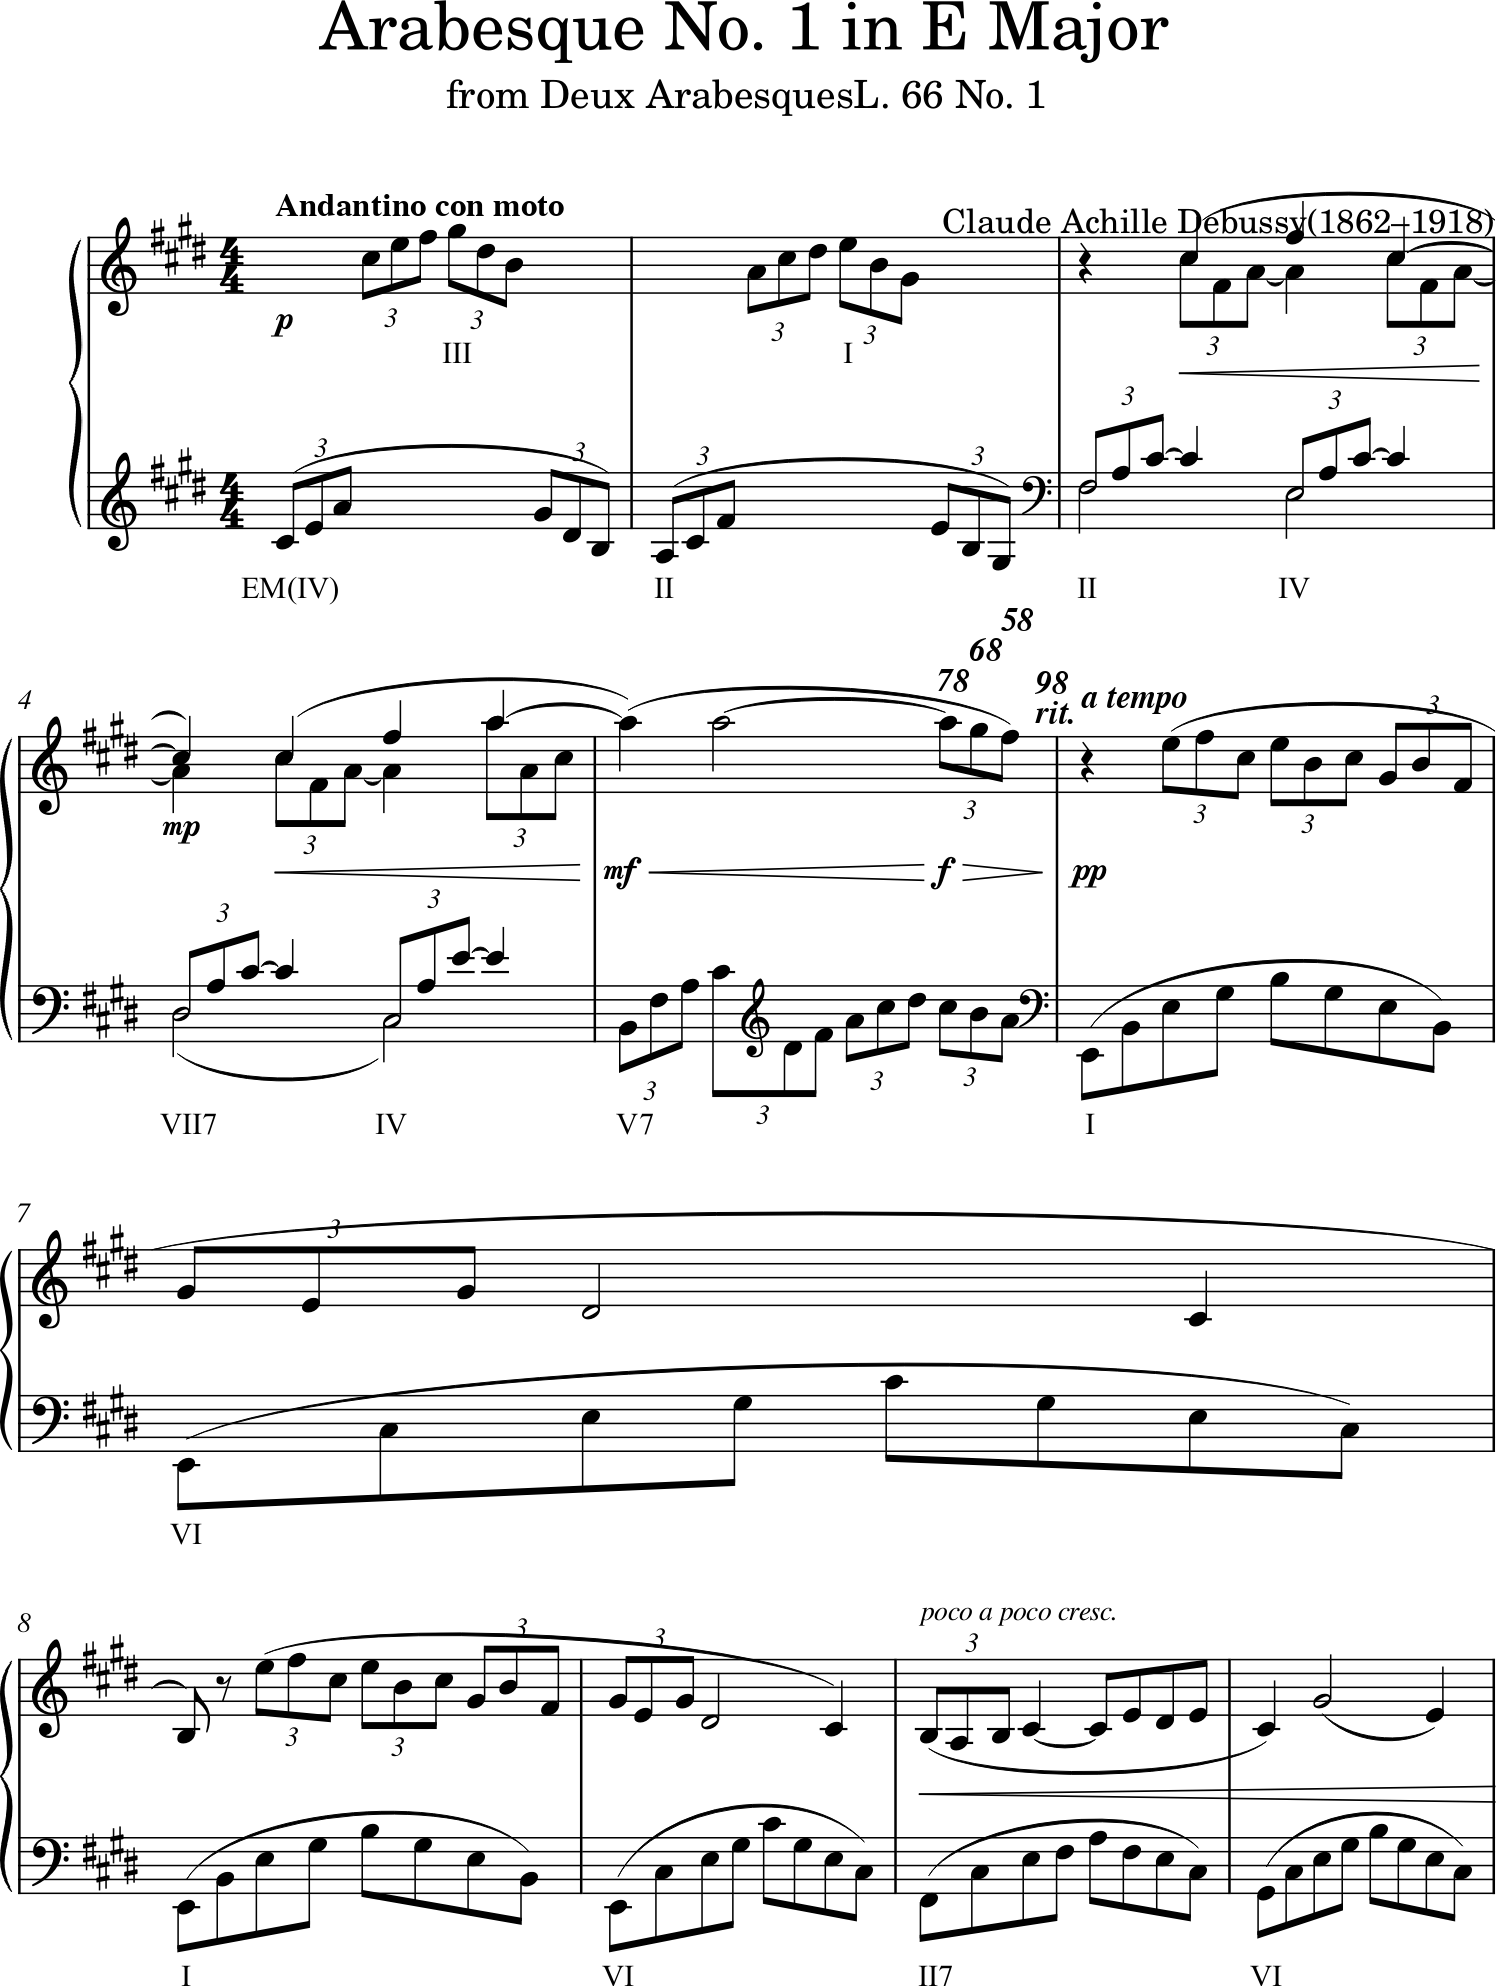

In [12]:
c.show()

In [13]:
partStream = c.parts.stream()

In [14]:
post = c.flattenParts().flat

In [30]:
for ts in c.recurse():
    print(ts)

<music21.text.TextBox 'Claude Ach...'>
<music21.text.TextBox 'Arabesque ...'>
<music21.text.TextBox 'from \n\nDeu...'>
<music21.stream.PartStaff P1-Staff1>
P1: Piano: Piano
<music21.stream.Measure 1 offset=0.0>
<music21.expressions.TextExpression 'Andantino ...'>
<music21.layout.SystemLayout>
<music21.clef.TrebleClef>
<music21.key.KeySignature of 4 sharps>
<music21.meter.TimeSignature 4/4>
<music21.dynamics.Dynamic p>
<music21.note.Rest rest>
<music21.note.Note C#>
<music21.note.Note E>
<music21.note.Note F#>
<music21.note.Note G#>
<music21.note.Note D#>
<music21.note.Note B>
<music21.note.Rest rest>
<music21.spanner.Slur <music21.note.Note C#><music21.note.Note B>>
<music21.spanner.Slur <music21.note.Note A><music21.note.Note G#>>
<music21.dynamics.Crescendo <music21.note.Note C#><music21.note.Note C#>>
<music21.spanner.Slur <music21.note.Note C#><music21.note.Note C#>>
<music21.dynamics.Crescendo <music21.note.Note C#><music21.note.Note A>>
<music21.spanner.Slur <music21.note.Note C#

In [15]:
post.show('text')

{0.0} <music21.instrument.Instrument 'P1: Piano: Piano'>
{0.0} <music21.layout.SystemLayout>
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.KeySignature of 4 sharps>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Note C#>
{0.0} <music21.spanner.Slur <music21.note.Note C#><music21.note.Note B>>
{0.0} <music21.spanner.Slur <music21.note.Note A><music21.note.Note G#>>
{0.0} <music21.dynamics.Crescendo <music21.note.Note C#><music21.note.Note C#>>
{0.0} <music21.spanner.Slur <music21.note.Note C#><music21.note.Note C#>>
{0.0} <music21.dynamics.Crescendo <music21.note.Note C#><music21.note.Note A>>
{0.0} <music21.spanner.Slur <music21.note.Note C#><music21.note.Note A>>
{0.0} <music21.spanner.Slur <music21.note.Note D#><music21.note.Note C#>>
{0.0} <music21.dynamics.Crescendo <music21.note.Note A><music21.note.Note A>>
{0.0} <music21.spanner.Slur <music21.note.Note A><music21.note.Note F#>>
{0.0} <music21.dynamics.Diminuendo <music21.note.Note A><music21.note.Note F#>>
{0.0

In [32]:
stream2 = post.makeMeasures()
for x in stream2.recurse():
    print(x)

<music21.stream.Measure 1 offset=0.0>
P1: Piano: Piano
<music21.layout.SystemLayout>
<music21.clef.TrebleClef>
<music21.key.KeySignature of 4 sharps>
<music21.meter.TimeSignature 4/4>
<music21.note.Note C#>
<music21.note.Note E>
<music21.note.Note A>
<music21.note.Note C#>
<music21.note.Note E>
<music21.note.Note F#>
<music21.note.Note G#>
<music21.note.Note D#>
<music21.note.Note B>
<music21.note.Note G#>
<music21.note.Note D#>
<music21.note.Note B>
<music21.stream.Measure 2 offset=4.0>
<music21.note.Note A>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.Note A>
<music21.note.Note C#>
<music21.note.Note D#>
<music21.note.Note E>
<music21.note.Note B>
<music21.note.Note G#>
<music21.note.Note E>
<music21.note.Note B>
<music21.note.Note G#>
<music21.stream.Measure 3 offset=8.0>
<music21.note.Note F#>
<music21.note.Note F#>
<music21.note.Note A>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note C#>
<music21.note.Note F#>
<music21.note.No

In [35]:
#doubling, duration, octave for importance value
for note in post.notes:
#     if 'ChordSymbol' not in note.classes:
#         continue
    print(note,note.duration,note.offset,float(note.beat))
    allnotes = list(note.pitches)
    for note1 in allnotes:
        print(note1.nameWithOctave)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")

<music21.note.Note C#> <music21.duration.Duration 1/3> 0.0 1.0
C#4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note E> <music21.duration.Duration 1/3> 1/3 1.3333333333333333
E4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note A> <music21.duration.Duration 1/3> 2/3 1.6666666666666667
A4
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note C#> <music21.duration.Duration 1/3> 1.0 2.0
C#5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note E> <music21.duration.Duration 1/3> 4/3 2.3333333333333335
E5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note F#> <music21.duration.Duration 1/3> 5/3 2.6666666666666665
F#5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note G#> <music21.duration.Duration 1/3> 2.0 3.0
G#5
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
<music21.note.Note D#> <music21.duration.Duration 1/3> 7/3 3.3333333333333335
D#5
+++

4 0.0
4 372.0
4 374.0


In [112]:
#modify a single note
post.notes[0].transpose(-2, inPlace=True)


In [132]:
#modify a note duration
post.notes[0].duration=duration.Duration('half')
post.notes[0].duration

<music21.duration.Duration 2.0>

In [127]:
#find index
idx=post.index(post.notes[0])
idx

45

In [125]:
#remove a note by idx
post.pop(idx)

<music21.note.Note C>

In [129]:
#modify note offset by idx
post[idx].offset=1